## Conversational RAG

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [2]:
from typing import List
from haystack.utils import Secret
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.chat.openai import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage
from haystack.components.joiners import BranchJoiner

In [3]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever


In [4]:
document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")

In [5]:
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy

Let's add more documents to our Elastic Document Store

In [12]:
converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

In [13]:
indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

🚅 Components
  - converter: TextFileToDocument
  - splitter: DocumentSplitter
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

In [14]:
indexing_pipeline.run({"converter": {"sources": ["../data/George_RR_Martin.txt"]}})

No abbreviations file found for en. Using default abbreviations.
Batches: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


{'writer': {'documents_written': 40}}

In [15]:
document_store.count_documents()

167

### Create an OpenAIChatGenerator
The [`OpenAIChatGenerator`](https://docs.haystack.deepset.ai/docs/openaichatgenerator?utm_campaign=developer-relations&utm_source=dlai) allows chat completions using OpenAI LLMs. 

Messages can come from the following roles:
- system
- assistant
- user

In [17]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))
replies = chat_generator.run(messages=[ChatMessage.from_user("What was written by George Martin?")])

In [18]:
rich.print(replies['replies'][0])

ChatMessage(
    _role=<ChatRole.ASSISTANT: 'assistant'>,
    _content=[
        TextContent(
            text='George R.R. Martin is best known for his series of epic fantasy novels, "A Song of Ice and Fire,"
which served as the basis for the hit HBO television series "Game of Thrones." The main books in this series 
include:\n\n1. **A Game of Thrones** (1996)\n2. **A Clash of Kings** (1998)\n3. **A Storm of Swords** (2000)\n4. 
**A Feast for Crows** (2005)\n5. **A Dance with Dragons** (2011)\n\nMartin has also been working on the forthcoming
novels **The Winds of Winter** and **A Dream of Spring**, which will complete the saga.\n\nIn addition to "A Song 
of Ice and Fire," Martin has written numerous other works, including:\n\n- Novels such as "Fevre Dream" (1982) and 
"The Kite Runner" (2012).\n- Short story collections like "A Song for Lya" (1976) and "Sandkings" (1981).\n- The 
"Wild Cards" series, which he edited and contributed to, is a shared universe of superhero stories.\n\nMartin is 
also known for his work in television and film, including being a writer and producer for the TV series "The 
Twilight Zone" and "Beauty and the Beast." His contributions to the science fiction and fantasy genres have made 
him a prominent figure in contemporary literature.'
        )
    ],
    _name=None,
    _meta={
        'model': 'gpt-4o-mini-2024-07-18',
        'index': 0,
        'finish_reason': 'stop',
        'usage': {
            'completion_tokens': 285,
            'prompt_tokens': 14,
            'total_tokens': 299,
            'completion_tokens_details': CompletionTokensDetails(
                accepted_prediction_tokens=0,
                audio_tokens=0,
                reasoning_tokens=0,
                rejected_prediction_tokens=0
            ),
            'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)
        }
    }
)

In [23]:
from haystack.components.converters import OutputAdapter

In [24]:
system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")

user_message_template ="""Given the conversation history and the provided supporting documents, give a brief answer to the question.
Note that supporting documents are not part of the conversation. If question can't be answered exclusive from supporting documents, say so.

    Conversation history:
    {% for memory in memories %}
        {{ memory.text }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""

user_message = ChatMessage.from_user(user_message_template)

In [32]:
query_rephrase_template = """
        Rewrite the question for search while keeping its meaning and key terms intact.
        If the conversation history is empty, DO NOT change the query.
        Use conversation history only if necessary, and avoid extending the query with your own knowledge.
        If no changes are needed, output the current question as is.

        Conversation history:
        {% for memory in memories %}
            {{ memory.text }}
        {% endfor %}

        User Query: {{query}}
        Rewritten Query:
"""

In [33]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))


chat_agent = Pipeline()
chat_agent.add_component("query_rephrase_prompt_builder", PromptBuilder(query_rephrase_template))
chat_agent.add_component("query_rephrase_llm", OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN)))
chat_agent.add_component("list_to_str_adapter", OutputAdapter(template="{{ replies[0] }}", output_type=str))
chat_agent.add_component("query_embedder", SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2"))
chat_agent.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3))
chat_agent.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
chat_agent.add_component("generator", chat_generator)




chat_agent.connect("query_rephrase_prompt_builder.prompt", "query_rephrase_llm")
chat_agent.connect("query_rephrase_llm.replies", "list_to_str_adapter")
chat_agent.connect("list_to_str_adapter.output", "query_embedder.text")
chat_agent.connect("query_embedder.embedding", "retriever.query_embedding")

# connections for RAG
chat_agent.connect("retriever.documents", "prompt_builder.documents")
chat_agent.connect("prompt_builder.prompt", "generator.messages")





🚅 Components
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: OpenAIGenerator
  - list_to_str_adapter: OutputAdapter
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: ElasticsearchEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - generator: OpenAIChatGenerator
🛤️ Connections
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> query_embedder.text (str)
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.messages (List[ChatMessage])

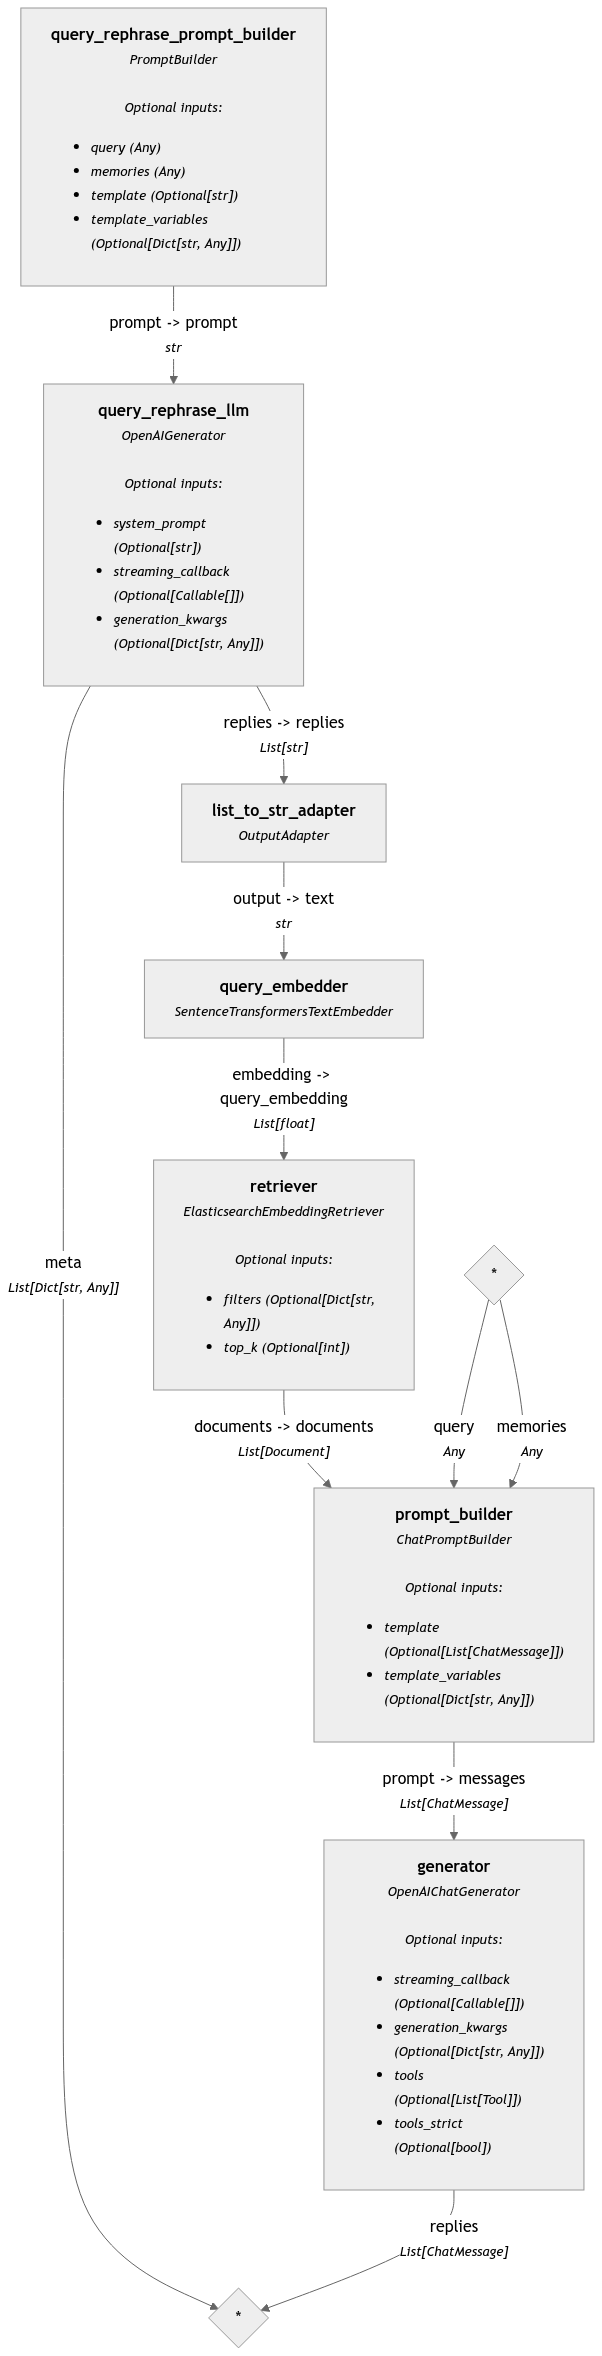

In [34]:
chat_agent.show()

In [43]:
messages = []
template = [system_message, user_message]
while True:
    user_input = input("INFO: Type 'exit' or 'quit' to stop\n")
    print(user_input)
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    response = chat_agent.run({"query_rephrase_prompt_builder": {"query": user_input, "memories":messages}, 
                               "prompt_builder": {"template":template, "query": user_input, "memories":messages},},
                                include_outputs_from={"query_rephrase_llm", "message_collector", "generator"})
    messages.append(ChatMessage.from_user(user_input))
    messages.extend(response['generator']['replies'])
    print(response['query_rephrase_llm']['replies'][0])
    print(response['generator']['replies'][0].text)




Who is Tolkien?


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Who is J.R.R. Tolkien?
Tolkien refers to John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa. He is a highly influential and celebrated figure in literary history, particularly in the genre of high fantasy.
What did he write?


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


What works did Tolkien write?
Tolkien wrote novels such as "The Hobbit" and "The Lord of the Rings," as well as essays and letters discussing his creative process and his role as a myth-maker.
Which was his most famous book?


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.89it/s]


What is Tolkien's most famous book?
His most famous book is "The Lord of the Rings."
exit


In [44]:
response

{'query_rephrase_llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 9,
     'prompt_tokens': 190,
     'total_tokens': 199,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}],
  'replies': ["What is Tolkien's most famous book?"]},
 'generator': {'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='His most famous book is "The Lord of the Rings."')], _name=None, _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 13, 'prompt_tokens': 253, 'total_tokens': 266, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_det

In [45]:
messages

[ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text='Who is Tolkien?')], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='Tolkien refers to John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa. He is a highly influential and celebrated figure in literary history, particularly in the genre of high fantasy.')], _name=None, _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 50, 'prompt_tokens': 161, 'total_tokens': 211, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text='What did he write?')], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[Te